In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

**Feature Matching**

In [2]:
gray1 = cv.imread("img_stitching1.jpg", cv.IMREAD_GRAYSCALE)
gray2 = cv.imread("img_stitching2.jpg", cv.IMREAD_GRAYSCALE)

Locate keypoints

In [3]:
#Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(gray1,None)
kp2, des2 = sift.detectAndCompute(gray2,None)

In [4]:
#define matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)

Find good matches (k nearest neightbors style)

In [5]:
matches = flann.knnMatch(des1,des2,k=2)

In [6]:
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches: 
    #m is distance to best match
    #n is distance to 2nd best match
    if m.distance < 0.7*n.distance:
        good.append(m)

Compute the Homography Matrix

In [7]:
if len(good)>10:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2) #extracting keypoints
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0) # error threshold is 5 pixels, compute homography M
    #transform img and locate the object
    matchesMask = mask.ravel().tolist()
    h,w = gray1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) #4 corner points of 1st img
    dst = cv.perspectiveTransform(pts,M) #get object location in 2nd img by applying the homography matrix
    gray2 = cv.polylines(gray2,[np.int32(dst)],True,255,3, cv.LINE_AA) #draw a polygon around the  object
else:
    print( "Not enough matches are found - {}/{}".format(len(good), 10) )
    matchesMask = None

Plot the matches

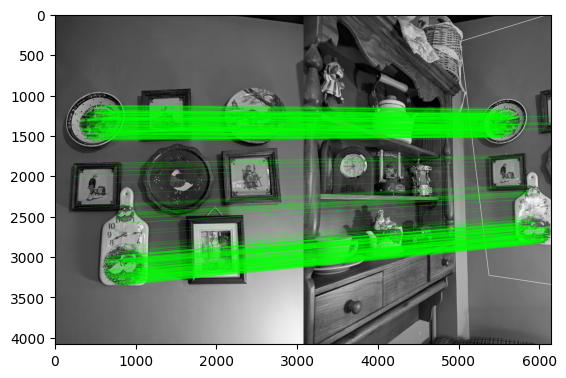

(<matplotlib.image.AxesImage at 0x13784234af0>, None)

In [8]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(gray1,kp1,gray2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

**Image Stitching**

Read in the images and  resize them

In [9]:
img1 = cv.imread("C:\RANSAC\img_stitching1.jpg") # H W C
h, w, col = img1.shape
#down scale the image
img1 = cv.resize(img1, (np.uint64(h*0.6), np.uint64(w * 0.6)))
cv.imshow("Img1",img1)
cv.waitKey(0)


-1

In [10]:
img2 = cv.imread("C:\RANSAC\img_stitching2.jpg") # H W C
h_, w_, col_ = img2.shape
#down scale the image
img2 = cv.resize(img2, (np.uint64(h_*0.6), np.uint64(w_*0.6)))
cv.imshow("Img1",img2)
cv.waitKey(0)

-1

In [11]:
imgs = [] #list of imgs

In [12]:
imgs.append(img1)
imgs.append(img2)


In [13]:
imgs = np.asarray(imgs)

**Create the stitcher and stitch the images**

In [14]:
stitcher = cv.Stitcher.create(mode=cv.STITCHER_SCANS)


In [15]:
stitcher.setPanoConfidenceThresh(-1) #confidence threshold, disable to allow more imgs to be considered to compute the result



In [16]:
(stat, output) = stitcher.stitch(imgs)

In [17]:
if stat != cv.STITCHER_OK:
  # checking if the stitching procedure is successful
  # .stitch() function returns a true value if stitching is done successfully
    print("Failllllllllllllll!!!")
else: 
    print('Success!')

Success!


Resize and show output

In [18]:
output_ = cv.resize(output, (np.uint64(output.shape[0]*0.2), np.uint64(output.shape[1]*0.2))) #20% of original size since image is big

In [19]:
cv.imshow("img", output_)
cv.waitKey(0)

-1